In [1]:
# import pydot, graphviz
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import keras
from keras import regularizers
from keras.models import Sequential, load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, concatenate, GlobalAveragePooling2D, Reshape, Lambda
from tensorflow.keras.layers import Permute
from tensorflow.keras.layers import LeakyReLU
from keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import xml.etree.ElementTree as ET
from sklearn.preprocessing import MinMaxScaler
from PIL import Image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras import Model
# import torch
# from transformers import ViTFeatureExtractor, ViTModel
# from torchvision.models import vision_transformer
from keras.callbacks import ModelCheckpoint
import gc
from tensorflow.keras import initializers

2024-06-24 11:13:09.453947: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 11:13:09.454055: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 11:13:09.558212: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def generate_anchor_boxes(n, scales, ratios, w, h):
    """
    Generate anchor boxes for object detection.
    
    Args:
    n (int): Number of anchors to generate per scale and ratio.
    scales (list): List of scales for the anchor boxes.
    ratios (list): List of aspect ratios for the anchor boxes.
    w (int): Width of the image.
    h (int): Height of the image.
    
    Returns:
    numpy.ndarray: An array of shape (n * len(scales) * len(ratios), 4)
                   containing the anchor boxes in (x1, y1, x2, y2) format.
    """
    
    center_x = np.linspace(0, w, n + 1)[:-1] + w / (2 * n)
    center_y = np.linspace(0, h, n + 1)[:-1] + h / (2 * n)
    cx, cy = np.meshgrid(center_x, center_y)
    
    centers = np.vstack([cx.ravel(), cy.ravel()]).transpose()
    
    anchor_boxes = []
    
    for (c_x, c_y) in centers:
        for scale in scales:
            for ratio in ratios:
                half_w = scale * np.sqrt(ratio) / 2
                half_h = scale / np.sqrt(ratio) / 2
                
                x1 = max(c_x - half_w, 0)
                y1 = max(c_y - half_h, 0)
                x2 = min(c_x + half_w, w)
                y2 = min(c_y + half_h, h)
                
                anchor_boxes.append([x1, y1, x2, y2]) 
    anchor_boxes = np.array(anchor_boxes)
    return anchor_boxes



def IoU(box1, box2):
    """
    Calculate Intersection over Union (IoU) between two bounding boxes.

    Args:
    box1 (list or numpy.ndarray): Coordinates of the first bounding box in format [x1, y1, x2, y2].
    box2 (list or numpy.ndarray): Coordinates of the second bounding box in format [x1, y1, x2, y2].

    Returns:
    float: Intersection over Union (IoU) score.
    """
    # Coordinates of intersection rectangle
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    # Area of intersection rectangle
    intersection_area = max(0, x2_inter - x1_inter + 1) * max(0, y2_inter - y1_inter + 1)

    # Area of both bounding boxes
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # Union area
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area

    return iou 



def assign_anchor_boxes(y, anchor_boxes, lower_threshold=0.2, upper_threshold=0.3):
    """
    Assign each anchor box to a ground truth box.
    
    Args:
    y (numpy.ndarray): Ground truth bounding boxes of shape (n, 4).
    anchor_boxes (numpy.ndarray): Anchor boxes of shape (m, 4).
    lower_threshold (float): Lower threshold for IoU.
    upper_threshold (float): Upper threshold for IoU.

    Returns:
    numpy.ndarray: An array of shape (n, 1) containing the index of the assigned ground truth box for each anchor box.
    """
    
    m = anchor_boxes.shape[0]
    n = y.shape[0]
    
    iou_matrix = np.zeros((m, n))
    
    for i in range(m):
        for j in range(n):
            iou_matrix[i, j] = IoU(anchor_boxes[i], y[j])
    assigned_gt_idx = np.full(m, -1)
    iou_list = []
    for i in range(m):
        gt_idx = np.argmax(iou_matrix[i])
        iou = iou_matrix[i, gt_idx]
        iou_list.append(iou)
        if iou >= upper_threshold:
            assigned_gt_idx[i] = gt_idx
        elif iou < lower_threshold:
            assigned_gt_idx[i] = -1 # background
        else:
            assigned_gt_idx[i] = -2 # ignore
    # print(max(iou_list))
    return assigned_gt_idx



def calculate_offset(anchor_boxes, y, assigned_boxes):
    """
    Calculate the offset values for anchor boxes.

    Args:
    anchor_boxes (numpy.ndarray): Anchor boxes of shape (n, 4).
    y (numpy.ndarray): Ground truth bounding boxes of shape (n, 4).

    Returns:
    numpy.ndarray: Offset values for xyxy of shape (n, 4).
    """
    
    offsets = np.zeros_like(anchor_boxes)

    for i, box in enumerate(anchor_boxes):
        if assigned_boxes[i] >= 0:
            gt_box = y[assigned_boxes[i]]
            offsets[i] = [(gt_box[0] - box[0]) / (box[2] - box[0]),
                          (gt_box[1] - box[1]) / (box[3] - box[1]),
                          (gt_box[2] - box[2]) / (box[2] - box[0]),
                          (gt_box[3] - box[3]) / (box[3] - box[1])]
    return offsets



def assign_class_label(anchor_boxes, assigned_boxes, true_labels):
    """
    Assign class labels to anchor boxes.

    Args:
    anchor_boxes (numpy.ndarray): Anchor boxes of shape (n, 4).
    assigned_boxes (numpy.ndarray): Index of the assigned ground truth box for each anchor box.
    true_labels (numpy.ndarray): true labels for each ground truth box.

    Returns:
    numpy.ndarray: Class labels for each anchor box.
    """

    class_labels = np.full(anchor_boxes.shape[0], -1)
    for i, idx in enumerate(assigned_boxes):
        if idx >= 0:
            class_labels[i] = true_labels[idx]
        elif idx == -1:
            class_labels[i] = 11
        else:
            class_labels[i] = 12
    return class_labels

def format_gt(ground_truth, true_labels,  scales, ratios, n, w, h):
    """
    Formats the ground truth data by generating anchor boxes, assigning boxes to ground truth objects,
    and calculating offsets.

    Parameters:
    - ground_truth (list): List of ground truth objects.
    - scales (list): List of scales for anchor boxes.
    - ratios (list): List of ratios for anchor boxes.
    - w (int): Width of the image.
    - h (int): Height of the image.

    Returns:
    - offsets (list): List of offsets calculated for each anchor box.
    - class_labels (list): List of class labels assigned to each anchor box.

    """

    anchor_boxes = generate_anchor_boxes(n, scales, ratios, w, h)
    assigned_boxes = assign_anchor_boxes(ground_truth, anchor_boxes)
    offsets = calculate_offset(anchor_boxes, ground_truth, assigned_boxes)
    class_labels = assign_class_label(anchor_boxes, assigned_boxes, true_labels)

    return offsets, class_labels

In [3]:
# Classify the defects into 12 categories
mapping = {
    "1_chongkong" : 0,
    "2_hanfeng" : 1,
    "3_yueyawan": 2,
    "4_shuiban": 3,
    "5_youban": 4,
    "6_siban": 5,
    "7_yiwu": 6,
    "9_zhehen": 7,
    "10_yaozhed": 8,
    "scratches": 9,
    "rolled-in_scale": 10,
    "8_yahen": 11,
    "inclusion" :6
}
mapping2 = {
    0 : "Punching Hole",
    1 : "Welding Line",
    2 : "Crescent Gap",
    3 : "Water Spot",
    4 : "Oil Spot",
    5 : "Silk Spot",
    6 : "Inclusion",
    11 : "Rolled Pit",
    7 : "Crease",
    8 : "Waist Folding",
    9 : "Scratches",
    10 : "Rolled in Scale"
}

In [4]:
# Define the image size
w_factor = 2048/224.0
l_factor = 1000/224.0
w = 224
l = 224
w_factor_2 = 200/224.0
l_factor_2 = 200/224.0

In [5]:
def get_annotations(directory, class_name, idx):
    """
    Retrieves annotations from an XML file and returns a list of bounding boxes.

    Args:
        directory (str): The path to the XML file.
        class_name (str): The name of the class.
        idx (int): The index.

    Returns:
        list: A list of bounding boxes, where each box is represented as a list of values.

    Raises:
        Exception: If an error occurs while parsing the XML file.

    """
    try:
        tree = ET.parse(directory)
        root = tree.getroot()
        boxes = []
        defect = -1
        objs = root.findall('object')
        for i in objs:
            name = i.find('name').text
            defect = mapping.get(name, 12)
            if defect != 12 and defect != 11:
                box = i.find('bndbox')
                xmin = float(box.find('xmin').text)
                ymin = float(box.find('ymin').text)
                xmax = float(box.find('xmax').text)
                ymax = float(box.find('ymax').text)

               
                if xmin > xmax:
                    temp = xmin
                    xmin = xmax
                    xmax = temp
                if ymin > ymax:
                    temp = ymin
                    ymin = ymax
                    ymax = temp

                box = []
                for i in range(5):
                    box.append(-1)
                box[0] = defect
                if class_name !='inclusion':
                    box[1] = (xmin)/w_factor
                    box[2] = (ymin)/l_factor
                    box[3] = (xmax)/w_factor
                    box[4] = (ymax)/l_factor
                elif (class_name=='inclusion' and idx<217):
                    box[1] = (xmin)/w_factor
                    box[2] = (ymin)/l_factor
                    box[3] = (xmax)/w_factor
                    box[4] = (ymax)/l_factor
                
                elif (class_name=='inclusion' and idx>= 217):
                    box[1] = (xmin)/w_factor_2
                    box[2] = (ymin)/l_factor_2
                    box[3] = (xmax)/w_factor_2
                    box[4] = (ymax)/l_factor_2
                    
                boxes.append(box)
            else:
                defect = -1
        if boxes:
            return boxes
        print(class_name, idx)
        return 0
    except:
        return 0

In [6]:
# Define the path to the dataset
data_dir = '/kaggle/input/metal-surfaces-defects/Metal-surfaces-defects'

In [7]:
# Test Usage of get_annotations
print(get_annotations("/kaggle/input/metal-surfaces-defects/Metal-surfaces-defects/lable/inclusion (3).xml", 'inclusion', 3))
print(get_annotations("/kaggle/input/metal-surfaces-defects/Metal-surfaces-defects/lable/crease (1).xml", 'crease', 1))

[[6, 185.28125, 46.592, 188.890625, 53.76], [2, 97.015625, 165.536, 122.71875, 224.0]]
[[7, 107.296875, 40.768, 223.78125, 55.775999999999996], [7, 52.28125, 40.096, 77.765625, 54.656]]


In [8]:
# Get the list of categories
all_items = os.listdir(data_dir)
categories = [item for item in all_items if os.path.isdir(os.path.join(data_dir, item)) and item != 'lable']
print(categories)

['inclusion', 'rolled_pit', 'oil_spot', 'crescent_gap', 'crease', 'waist_folding', 'rolled_in_scale', 'scratches', 'water_spot', 'punching_hole', 'silk_spot', 'welding_line']


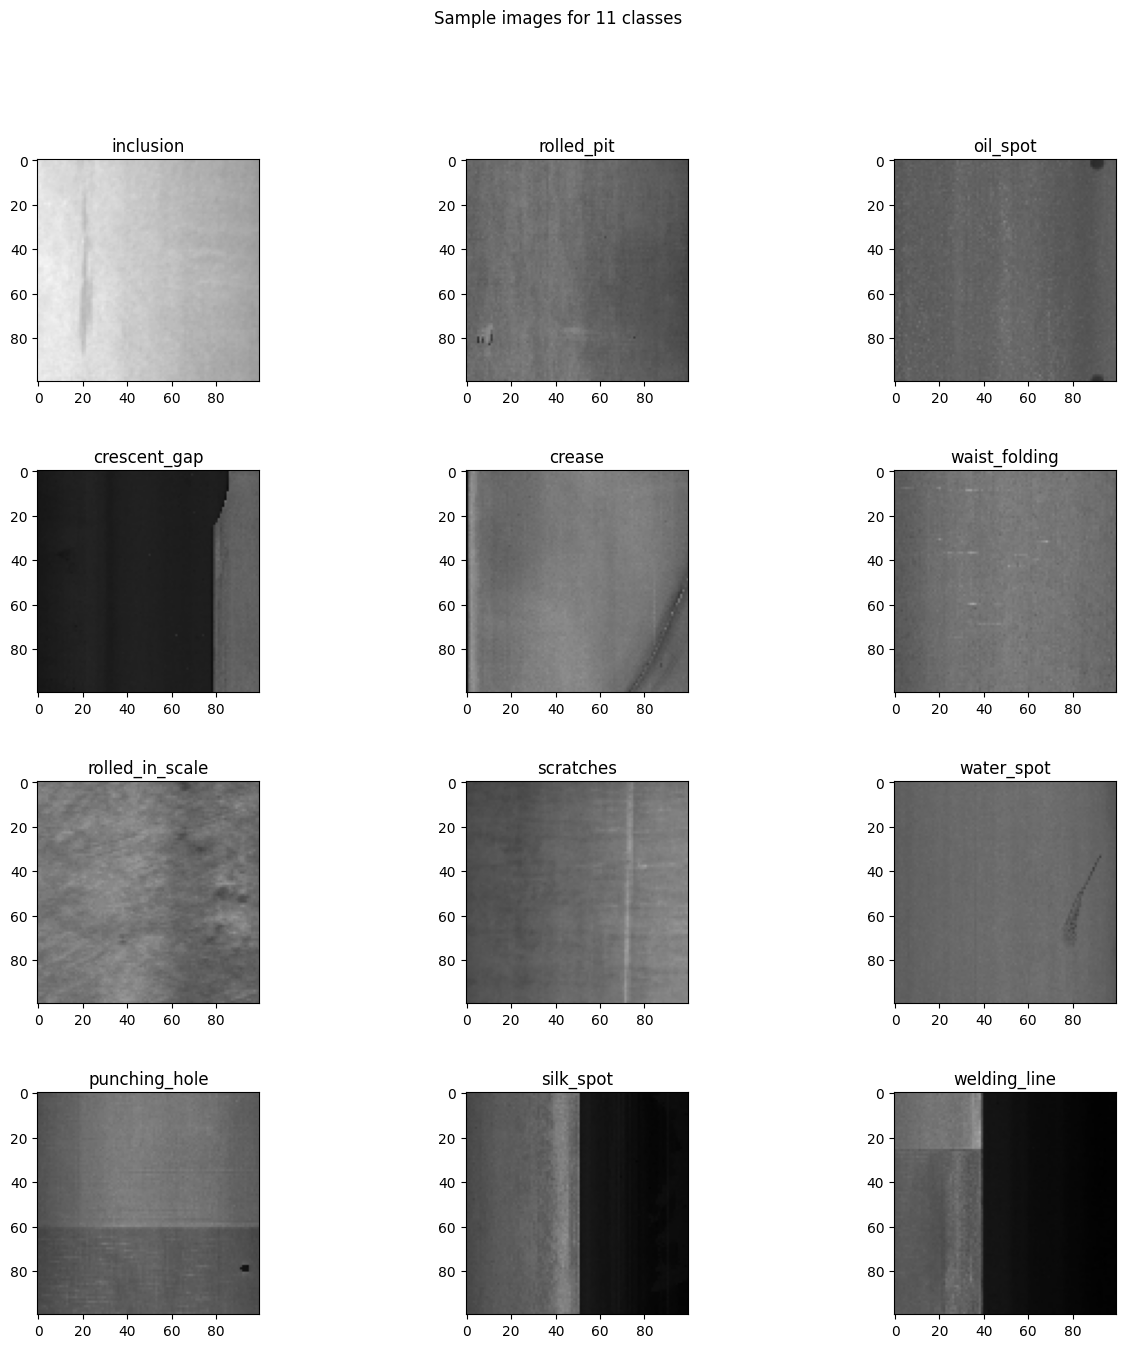

In [9]:
# Plot sample images for each category
def load_sample_images(data_dir, categories):
    """
    Load sample images from the specified data directory for the given categories.

    Args:
        data_dir (str): The path to the directory containing the image data.
        categories (list): A list of category names.

    Returns:
        list: A list of sample images loaded from the specified data directory.
    """
    sample_images = []
    for category in categories:
        category_path = os.path.join(data_dir, category)
        img_path = next(os.path.join(category_path, img) for img in os.listdir(category_path))
        img = cv2.imread(img_path)
        img = cv2.resize(img, (100, 100))
        sample_images.append(img)
    return sample_images

def plot_sample_images(sample_images, categories):
    """
    Plot sample images for each category.

    Args:
        sample_images (list): List of sample images to be plotted.
        categories (list): List of categories corresponding to the sample images.

    Returns:
        None
    """
    fig = plt.figure(figsize=(15, 15))
    spec = gridspec.GridSpec(ncols=3, nrows=4, width_ratios=[1, 1, 1], wspace=0.4, hspace=0.4, height_ratios=[1, 1, 1, 1])
    fig.suptitle("Sample images for 11 classes")
    for i, img in enumerate(sample_images):
        ax = fig.add_subplot(spec[i])
        ax.imshow(img, cmap='gray')
        ax.set_title(f"{categories[i]}")  
    plt.show()

sample_images = load_sample_images(data_dir, categories)
plot_sample_images(sample_images, categories)

In [10]:
def load_data(data_dir, categories):
    """
    Load data from the specified data directory for the given categories.

    Args:
        data_dir (str): The path to the directory containing the image data.
        categories (list): A list of category names.

    Returns:
        None
    """
    X = []
    y = []
    for category in categories:
        category_path= os.path.join(data_dir, category)
        cnt=1

        for img in os.listdir(category_path):
            img_path= os.path.join(category_path, img)
            img= cv2.imread(img_path)
            annotation = get_annotations(f"{data_dir}/lable/{category} ({cnt}).xml", category, cnt)
            cnt+=1

            if (annotation):
                img = cv2.resize(img, (w, l))
    #             img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #             img= np.expand_dims(img, axis=0)
                X.append(img)
                y.append(annotation)
    return X, y

In [11]:
X, y = load_data(data_dir, categories)

inclusion 59
inclusion 124
rolled_pit 1
rolled_pit 3
rolled_pit 4
rolled_pit 5
rolled_pit 6
rolled_pit 7
rolled_pit 8
rolled_pit 9
rolled_pit 10
rolled_pit 11
rolled_pit 12
rolled_pit 13
rolled_pit 14
rolled_pit 16
rolled_pit 17
rolled_pit 18
rolled_pit 19
rolled_pit 20
rolled_pit 21
rolled_pit 22
rolled_pit 23
rolled_pit 24
rolled_pit 25
rolled_pit 26
rolled_pit 27
rolled_pit 29
rolled_pit 30
crease 20
crease 21
crease 24
waist_folding 1
waist_folding 24
waist_folding 25
waist_folding 26
waist_folding 27
waist_folding 28
waist_folding 29
waist_folding 30
waist_folding 31
water_spot 165


In [12]:
# Split the data into training, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

In [13]:
X_train = np.array(X_train, dtype= 'float32')
X_val = np.array(X_val, dtype= 'float32')
X_test = np.array(X_test, dtype= 'float32')

In [14]:
y_train[1]

[[5, 187.578125, 148.28799999999998, 209.78125, 212.79999999999998]]

In [15]:
def split_gt(y):
    """
    Splits the ground truth annotations into separate lists for classes and dimensions.

    Args:
        y (list): The ground truth annotations.

    Returns:
        tuple: A tuple containing two lists - classes and dimensions.
               The classes list contains the class labels for each annotation.
               The dimensions list contains the dimensions (bounding boxes) for each annotation.
    """
    classes = []
    dims = []
    for i in range(len(y)):
        tmp_classes = []
        tmp_dims = []
        for j in range(len(y[i])):
            tmp_classes.append(y[i][j][0])
            tmp_dims.append(y[i][j][1:])
        classes.append(tmp_classes)
        dims.append(tmp_dims)
    return classes, dims

In [16]:
classes_train, dims_train = split_gt(y_train)
classes_val, dims_val = split_gt(y_val)
classes_test, dims_test = split_gt(y_test)

In [17]:
n = 5
scales = [32, 64, 128]
ratios = [0.2, 2, 5]

In [18]:
# import importlib
# ab = importlib.reload(ab)

In [19]:
def generate_dims_offsets_and_classes(dims, classes, scales, ratios, n, w, l):
    """
    Generate offsets for each image dimension based on the given scales, ratios, and number of anchor boxes.
    
    Parameters:
    - scales (list): List of scales for anchor boxes.
    - ratios (list): List of ratios for anchor boxes.
    - n (int): Number of anchor boxes per location.
    - dims (list): List of image dimensions.
    - w (int): Width of the image.
    - l (int): Length of the image.
    
    Returns:
    - offsets (list): List of offsets for each image dimension.
    """
    offsets = []
    true_classes = []
    for img_dim, cls in zip(dims, classes):
        offset, clss = format_gt(np.array(img_dim), np.array(cls) , scales, ratios, n, w, l)
        offsets.append(offset)
        true_classes.append(clss)
    return offsets, true_classes

In [20]:
offset_train, cls_train  = generate_dims_offsets_and_classes(dims_train, classes_train, scales, ratios, n, w, l)
offset_val, cls_val  = generate_dims_offsets_and_classes(dims_val, classes_val, scales, ratios, n, w, l)
offset_test, cls_test  = generate_dims_offsets_and_classes(dims_test, classes_test, scales, ratios, n, w, l)

In [21]:
for i in offset_train[0]:
    print(i)

[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[ 0.4877715   0.15158148 -0.03455284  0.07325098]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[ 0.4877715   0.11929151 -0.03455284 -0.15537353]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 

In [22]:
def extract_min(lst, index):
    """
    Extracts the minimum value from a nested list based on the specified index.
    
    Args:
        lst (list): A nested list containing numerical values.
        index (int): The index to compare the values.
        
    Returns:
        int: The minimum value found in the nested list.
    """
    minn = 10000000
    for i in range(len(lst)):
        for j in range(len(lst[i])):
            if lst[i][j][index] < minn:
                minn = lst[i][j][index]
    return minn

In [23]:
def extract_max(lst, index):
    """
    Extracts the maximum value from a nested list based on the given index.
    
    Args:
        lst (list): A nested list containing numerical values.
        index (int): The index to compare the values.
        
    Returns:
        int: The maximum value found in the nested list based on the given index.
    """
    maxx = -10000000
    for i in range(len(lst)):
        for j in range(len(lst[i])):
            if lst[i][j][index] > maxx:
                maxx = lst[i][j][index]
    return maxx

In [24]:
def maxminscaler(lst, maxx, minn, index):
    """
    Applies max-min scaling to a list of values.

    Parameters:
    lst (list): The list of values to be scaled.
    maxx (float): The maximum value for scaling.
    minn (float): The minimum value for scaling.
    index (int): The index of the value to be scaled within each sublist.

    Returns:
    list: The scaled list of values.
    """
    for i in range(len(lst)):
        for j in range(len(lst[i])):
            if lst[i][j][index] != 0:
                lst[i][j][index] = (lst[i][j][index] - minn) / (maxx - minn)
    return lst

In [25]:
xmin_min = extract_min(offset_train, 0)
xmin_max = extract_max(offset_train, 0)
xmax_min = extract_min(offset_train, 1)
xmax_max = extract_max(offset_train, 1)
ymin_min = extract_min(offset_train, 2)
ymin_max = extract_max(offset_train, 2)
ymax_min = extract_min(offset_train, 3)
ymax_max = extract_max(offset_train, 3)

In [26]:
offset_train = maxminscaler(offset_train, xmin_max, xmin_min, 0)
offset_train = maxminscaler(offset_train, xmax_max, xmax_min, 1)
offset_train = maxminscaler(offset_train, ymin_max, ymin_min, 2)
offset_train = maxminscaler(offset_train, ymax_max, ymax_min, 3)

offset_val = maxminscaler(offset_val, xmin_min, xmin_max, 0)
offset_val = maxminscaler(offset_val, xmax_min, xmax_max, 1)
offset_val = maxminscaler(offset_val, ymin_min, ymin_max, 2)
offset_val = maxminscaler(offset_val, ymax_min, ymax_max, 3)

offset_test = maxminscaler(offset_test, xmin_min, xmin_max, 0)
offset_test = maxminscaler(offset_test, xmax_min, xmax_max, 1)
offset_test = maxminscaler(offset_test, ymin_min, ymin_max, 2)
offset_test = maxminscaler(offset_test, ymax_min, ymax_max, 3)

In [27]:
num_classes = 13

for i in range(len(cls_train)):
    cls_train[i] = np.array(cls_train[i], dtype = 'float').astype('float64').reshape((-1,1))
    cls_train[i] = to_categorical(cls_train[i], num_classes=num_classes)

for i in range(len(offset_train)):
    offset_train[i] = np.array(offset_train[i], dtype = 'float')

for i in range(len(cls_val)):
    cls_val[i] = np.array(cls_val[i], dtype = 'float').astype('float64').reshape((-1,1))
    cls_val[i] = to_categorical(cls_val[i], num_classes=num_classes)

for i in range(len(offset_val)):
    offset_val[i] = np.array(offset_val[i], dtype = 'float')

for i in range(len(cls_test)):
    cls_test[i] = np.array(cls_test[i], dtype = 'float').astype('float64').reshape((-1,1))
    cls_test[i] = to_categorical(cls_test[i], num_classes=num_classes)

for i in range(len(offset_test)):
    offset_test[i] = np.array(offset_test[i], dtype = 'float')

In [28]:
print(len(offset_train[0]))
offset_train = np.array(offset_train, dtype = 'float')
offset_val = np.array(offset_val, dtype = 'float')
offset_test = np.array(offset_test, dtype = 'float')
cls_train = np.array(cls_train, dtype = 'float')
cls_val = np.array(cls_val, dtype = 'float')
cls_test = np.array(cls_test, dtype = 'float')

225


In [29]:
for i in offset_train[0]:
    print(i)

[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0.9273302  0.81118593 0.25261802 0.2687002 ]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0.9273302  0.79973299 0.25261802 0.18921022]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.

In [30]:
from transformers import AutoImageProcessor, TFViTModel
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
extract = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [31]:
@tf.function
def maee(y_true, y_pred):
    """
    Calculates the mean absolute error between the true and predicted values.
    
    Parameters:
    y_true (Tensor): The true values.
    y_pred (Tensor): The predicted values.
    
    Returns:
    float: The mean absolute error.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    s = tf.constant(0.0, dtype=tf.float32)
    cnt = tf.constant(0.0, dtype=tf.float32)
    
    for i in range(len(y_true)):
        if (tf.reduce_sum(y_true[i]) != 0):
            s += tf.reduce_sum(abs(y_true[i] - y_pred[i]))
            cnt += 1.0
    if cnt > 0.0:
        s /= cnt
    return s


In [32]:
@tf.function
def msee(y_true, y_pred):
    """
    Calculates the mean squared error (MSE) between the true labels (y_true) and the predicted labels (y_pred).

    Parameters:
    - y_true: The true labels.
    - y_pred: The predicted labels.

    Returns:
    - The mean squared error between y_true and y_pred.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    s = tf.constant(0.0, dtype=tf.float32)
    cnt = tf.constant(0.0, dtype=tf.float32)
    
    for i in tf.range(len(y_true)):
        if tf.reduce_sum(y_true[i]) != 0:
            s += tf.reduce_sum(tf.square(y_true[i] - y_pred[i]))
            cnt += 1.0
    
    if cnt > 0.0:
        s /= cnt
    return s

In [33]:
@tf.function
def categorical_crossentropy2(y_true, y_pred):
    m = y_true.shape[0]
    loss = tf.zeros([])
    for i in range(m):
        for j in range(y_true[i].shape[0]):
            loss += tf.keras.losses.CategoricalCrossentropy()(y_true[i][j], y_pred[i][j])

    loss /= tf.cast(m, tf.float32)
    return loss

In [34]:
c = tf.keras.metrics.CategoricalAccuracy()

@tf.function
def accuracy3(y_true, y_pred):
    m = y_true.shape[0]
    total_accuracy = tf.constant(0.0, dtype=tf.float32)
    
    for i in range(m):
        cnt = tf.constant(0, dtype=tf.float32)
        accuracy_sum = tf.constant(0.0, dtype=tf.float32)
        
        for j in range(tf.shape(y_true[i])[0]):
            mask = tf.logical_or(
                tf.not_equal(tf.argmax(y_true[i][j], axis=-1), 11),  # Exclude class 12 (index 11)
                tf.not_equal(tf.argmax(y_true[i][j], axis=-1), 12)   # Exclude class 13 (index 12)
            )
            
            if tf.reduce_all(mask):  # Ensure that all elements are valid
                c.update_state(y_true[i][j], y_pred[i][j])
                accuracy_sum += c.result()
                cnt += 1

        if cnt > 0:  # Ensure we don't divide by zero
            total_accuracy += accuracy_sum / cnt
    
    total_accuracy /= tf.cast(m, tf.float32)
    return total_accuracy

In [35]:
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.8  # Allocate 80% of the available GPU memory
# tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [36]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('class_output_accuracy2') is not None and logs.get('class_output_accuracy2') > 0.85 \
        and logs.get('val_class_output_accuracy2') is not None and logs.get('val_class_output_accuracy2') > 0.85:
            self.model.stop_training = True

In [37]:
callbacks= myCallback()

In [38]:
class CustomModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, filepath, save_freq=5, **kwargs):
        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.save_freq = save_freq
        self.epochs_since_last_save = 0
        self.checkpoint_callback = ModelCheckpoint(filepath=self.filepath,
                                                   save_weights_only=True,
                                                   save_best_only=True,
                                                   monitor='val_loss',
                                                   mode='min',
                                                   **kwargs)

    def set_model(self, model):
        super(CustomModelCheckpoint, self).set_model(model)
        self.checkpoint_callback.set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.save_freq:
            self.epochs_since_last_save = 0
            self.checkpoint_callback.on_epoch_end(epoch, logs)

# Use the custom callback
checkpoint_callback = CustomModelCheckpoint(filepath='weights_epoch_{epoch:02d}.weights.h5',
                                            save_freq=5,
                                            verbose=1)

In [ ]:
X_train_1= image_processor(X_train, return_tensors="tf")
X_val_1= image_processor(X_val, return_tensors="tf")
X_test_1= image_processor(X_test, return_tensors="tf")

In [ ]:
# import gc
# del X_train
# del X_val
# del X_test
# gc.collect()

In [ ]:
X_train_1= X_train_1['pixel_values']
X_val_1 = X_val_1['pixel_values']
X_test_1 = X_test_1['pixel_values']

In [ ]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [ ]:
# @tf.function
# def extract_tf(input):
#     return extract(input)

# X_train_1 = tf.expand_dims(extract_tf(X_train_1)['last_hidden_state'], axis=-1)

In [ ]:
# gpus = tf.config.list_physical_devices('GPU')
# tf.config.set_logical_device_configuration(
#         gpus[0],
#         [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])

In [ ]:
# ViT = tf.expand_dims(extract(X)['last_hidden_state'], axis=-1)

In [ ]:
len(X_train_1)

In [ ]:
X_train_1.shape

In [ ]:
# batch_size = 32  # Define your batch size
# Create TensorFlow data datasets
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train_1, offset_train))
# Batch the datasets
# train_dataset = X_train_ex.batch(batch_size)

In [ ]:
class MyModel(tf.keras.Model):
    def __init__(self, base, **kwargs):
        super().__init__(**kwargs)
        self.base = base
        self.base.trainable = False
        self.conv1 = Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu')
        self.maxpool1 = MaxPooling2D(pool_size=(2, 2))
        self.conv2 = Conv2D(64, kernel_size=(3, 3), padding='valid', activation='relu')
        self.maxpool2 = MaxPooling2D(pool_size=(2, 2))
        self.flatten = Flatten()
        self.dense_class1 = Dense(512, activation=LeakyReLU(negative_slope=0.01), 
                                  kernel_initializer='glorot_uniform',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.drop = Dropout(0.2)
        self.dense_class2 = Dense(256, activation=LeakyReLU(negative_slope=0.01), 
                                  kernel_initializer='glorot_uniform',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.output_dense_class1 = Dense(225*13, activation=LeakyReLU(negative_slope=0.01), 
                                         kernel_initializer='glorot_uniform',
                                         kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.output_reshape_class1 = Reshape((225, 13))
        self.softmax_single_class = Dense(13, activation='softmax')
        self.concatenate = tf.keras.layers.Concatenate(axis=-1)
        self.output_reshape_class2 = Reshape((225, 13), name='class_output')
        
        self.dense_reg1 = Dense(256, activation=LeakyReLU(negative_slope=0.01),
                                kernel_initializer='glorot_uniform',
                                kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.dense_reg2 = Dense(128, activation=LeakyReLU(negative_slope=0.01),
                                kernel_initializer='glorot_uniform',
                                kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.dense_reg3 = Dense(128, activation=LeakyReLU(negative_slope=0.01),
                                kernel_initializer='glorot_uniform',
                                kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.dense_reg4 = Dense(64, activation=LeakyReLU(negative_slope=0.01),
                                kernel_initializer='glorot_uniform',
                                kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.output_dense_reg1 = Dense(225*4)
        self.output_reshape_reg1 = Reshape((225, 4))
        self.sigmoid_single_reg = Dense(4, activation='sigmoid')
        self.output_reshape_reg2 = Reshape((225, 4), name='reg_output')
        
    def call(self, inputs):
        x = self.base(inputs)
        x = tf.expand_dims(x['last_hidden_state'], axis=-1)
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        
        y = self.dense_class1(x)
        y = self.drop(y)
        y = self.dense_class2(y)
        y = self.drop(y)
        y = self.output_dense_class1(y)
        y = self.output_reshape_class1(y)
        softmax_layers = []
        for i in range(225):
            row = Lambda(lambda x: x[:, i, :])(y)
            softmax = self.softmax_single_class(row)
            softmax_layers.append(softmax)
        
        y = self.concatenate(softmax_layers)
        y = self.output_reshape_class2(y)
            
        z = self.dense_reg1(x)
        z = self.drop(z)
        z = self.dense_reg2(z)
        z = self.drop(z)
        z = self.dense_reg3(z)
        z = self.dense_reg4(z)
        z = self.output_dense_reg1(z)
        z = self.output_reshape_reg1(z)
        reg_layers = []
        for i in range(225):
            row = Lambda(lambda x: x[:, i, :])(z)
            out = self.sigmoid_single_reg(row)
            reg_layers.append(out)
        z = self.concatenate(reg_layers)
        z = self.output_reshape_reg2(z)
        return {'class_output': y, 'reg_output': z}

In [ ]:
model = MyModel(extract)

In [ ]:
model(np.array([X_train_1[0]]))

In [ ]:
model.summary()

In [ ]:
model.load_weights("/kaggle/input/vit-saved-weights/tensorflow2/eight/1/weights_epoch_08.weights.h5")

In [ ]:
# strategy = tf.distribute.MirroredStrategy()

# with strategy.scope():
model.compile(optimizer='SGD',
              loss={'class_output': categorical_crossentropy2,
                    'reg_output': msee},
              loss_weights={'class_output': 1.0, 'reg_output': 1.0},
              metrics={'class_output': accuracy3,
                       'reg_output': maee},
              run_eagerly=True)

# Fit the model
history = model.fit(X_train_1, {'class_output': cls_train, 'reg_output': offset_train}, 
                    batch_size=8,
                    epochs=200,
                    validation_data=(X_val_1, {'class_output': cls_val, 'reg_output': offset_val}),
                    callbacks=[checkpoint_callback, callbacks])

In [ ]:
for i in offset_train[0]:
    print(i)